<a href="https://colab.research.google.com/github/margot-bonilla/violent-behaviour-recognition/blob/master/TFM_2024_Iteration_keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Violence Detection

# Set Up

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

# Crate necessary folders for the execution
info_path = '/content/Info'
if not os.path.exists(info_path):
    os.makedirs(info_path)

logs_path = '/content/logs'
if not os.path.exists(logs_path):
    os.makedirs(logs_path)

models_path = '/content/models/checkpoints'
if not os.path.exists(models_path):
    os.makedirs(models_path)

## Constant information to set the data and engineering resources

In [7]:
# Path information to load videos and annotations
import os

ROOT_PATH = r"/content/drive/MyDrive/UOC/TFM_2"
ANNOTATIONS_PATH = os.path.join(ROOT_PATH, "Annotations")
VIDEOS_PATH = os.path.join(ROOT_PATH, "Videos")
INFO_PATH = "Info"
MODELS_PATH = 'models'

LOGS_PATH = "logs"

DATASET_TRAIN_PATH = os.path.join(INFO_PATH, "violence_detection_train.hdf5")
DATASET_VAL_PATH = os.path.join(INFO_PATH, "violence_detection_val.hdf5")
DATASET_TEST_PATH = os.path.join(INFO_PATH, "violence_detection_test.hdf5")

## Krakov
KRAKOV_VIDEOS_PATH = os.path.join(ROOT_PATH, "Videos")
INCLUDE_KRAKOV = True

## Hockey
HOCKEY_VIDEOS_PATH = os.path.join(ROOT_PATH, "Hockey", "data")
INCLUDE_HOCKEY = True

## Movies
MOVIES_VIDEOS_PATH = os.path.join(ROOT_PATH, "movies")
INCLUDE_MOVIES = True

## RWF 2000
RWF2000_VIDEOS_PATH = os.path.join(ROOT_PATH, "2 - data")
INCLUDE_RWF2000 = True

## RWF 2000
VIOLENT_VIDEOS_PATH = os.path.join(ROOT_PATH, "violentFlows", "ForTal")
INCLUDE_VIOLENT = True

# Set the cells/process you want to run
CREATE_DATASET = False
PLOT_FRAME_DISTRIBUTION = False
IS_TEST_RUN = False
TEST_SIZE = 10
INSTALL_STUFF = False
LOAD_MODEL = True

EPOCHS = 10 if IS_TEST_RUN else 70
IMG_HEIGHT = 128
IMG_WIDTH = 128
APPLY_GRAYSCALE = True
IMG_CHANNELS = 1 if APPLY_GRAYSCALE else 3
BODY_KEYPOINTS = 13
BATCH_SIZE = 5

MAX_NUM_FRAMES = 40
APPLY_DATA_AUGMENTATION = False

In [8]:
# global variables
# total_videos will contain the full path of each of the videos
total_normal_videos = list()
total_violent_videos = list()

In [9]:
# Dedup videos
all_video_names = set()

In [10]:
def include_videos(video_path, normal_prefix):
  for v in os.listdir(video_path):
    total_path = os.path.join(video_path, v)
    if v.startswith(normal_prefix) and v not in all_video_names:
      total_normal_videos.append(total_path)
      all_video_names.add(v)
    elif v not in all_video_names:
      total_violent_videos.append(total_path)
      all_video_names.add(v)

In [11]:
if INCLUDE_KRAKOV:
  include_videos(os.path.join(KRAKOV_VIDEOS_PATH), 'Normal')

In [12]:
if INCLUDE_HOCKEY:
  include_videos(os.path.join(HOCKEY_VIDEOS_PATH), 'no')

In [13]:
if INCLUDE_MOVIES:
  for f in os.listdir(MOVIES_VIDEOS_PATH):
    folder_path_normal = os.path.join(MOVIES_VIDEOS_PATH, f, "NonViolence")
    folder_path_violent = os.path.join(MOVIES_VIDEOS_PATH, f, "Violence")
    for normal in os.listdir(folder_path_normal):
      if normal not in all_video_names:
        total_normal_videos.append(os.path.join(folder_path_normal, normal))
        all_video_names.add(normal)
    for violent in os.listdir(folder_path_violent):
      if violent not in all_video_names:
        total_violent_videos.append(os.path.join(folder_path_violent, violent))
        all_video_names.add(violent)

In [14]:
if INCLUDE_RWF2000:
  for f in os.listdir(RWF2000_VIDEOS_PATH):
    folder_path_normal = os.path.join(RWF2000_VIDEOS_PATH, f, "NonFight")
    folder_path_violent = os.path.join(RWF2000_VIDEOS_PATH, f, "Fight")
    for normal in os.listdir(folder_path_normal):
      if normal not in all_video_names:
        total_normal_videos.append(os.path.join(folder_path_normal, normal))
        all_video_names.add(normal)
    for violent in os.listdir(folder_path_violent):
      if violent not in all_video_names:
        total_violent_videos.append(os.path.join(folder_path_violent, violent))
        all_video_names.add(violent)

In [15]:
if INCLUDE_VIOLENT:
  for v in os.listdir(VIOLENT_VIDEOS_PATH):
    if v not in all_video_names:
      total_violent_videos.append(os.path.join(VIOLENT_VIDEOS_PATH, v))
      all_video_names.add(v)

In [16]:
# Dedup videos
print("all video names: ", len(all_video_names))
print("all dedup video names: ", len(total_normal_videos) + len(total_violent_videos))

all video names:  6678
all dedup video names:  6678


In [17]:
# Shuffle videos to increase diversity
import random

random.shuffle(total_normal_videos)
random.shuffle(total_violent_videos)

In [18]:
print(f'Total of normal videos included: {len(total_normal_videos)}')
print(f'Total of violent videos included: {len(total_violent_videos)}')

Total of normal videos included: 4623
Total of violent videos included: 2055


In [19]:
# Cut the volume of videos for testing purposes

if IS_TEST_RUN:
  total_normal_videos = total_normal_videos[:TEST_SIZE + 5] # to handle inbalance
  total_violent_videos = total_violent_videos[:TEST_SIZE]
  print(f'Total normal videos: {len(total_normal_videos)}')
  print(f'Total violent videos: {len(total_violent_videos)}')

## Libraries that you may need to run the notebook

In [20]:
# Execute this if you are not able to install tensorflow properly
if INSTALL_STUFF:
    !pip install tensorflow[and-cuda]
    !pip install pydot
    !pip install graphviz

## Plot distribution

In [21]:
import cv2
import os
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import progressbar

def create_frame_distribution(videos):
    number_of_frames = list()
    bar = progressbar.ProgressBar(maxval=len(videos), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    processed = 0
    for video in videos:
        try:
            cap = cv2.VideoCapture(video)
            property_id = int(cv2.CAP_PROP_FRAME_COUNT)
            length = int(cv2.VideoCapture.get(cap, property_id))
            number_of_frames.append(length)
            cap.release()

            processed += 1
            bar.update(processed)

        except Exception as e:
            print(f"ERROR: {e.message}")
    bar.finish()

    return number_of_frames

def plot_frame_distribution(number_of_frames):
    frame_counts = np.array(number_of_frames)
    print("Number of unique frame counts:", len(frame_counts))
    print("Max frames in a video:", frame_counts.max())
    print("Min frames in a video:", frame_counts.min())
    print("Average frames per video:", frame_counts.mean())
    print("Median frames per video:", np.median(frame_counts))
    mode_value = st.mode(frame_counts).mode
    print("Mode frames per video:", mode_value)
    print("Videos over 2k frames:", np.sum(frame_counts > 2000))
    print("Videos over 5k frames:", np.sum(frame_counts > 5000))

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frame_counts, bins=100, color='skyblue', edgecolor='black')

    # Add vertical lines for mean, median, and mode
    plt.axvline(frame_counts.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(np.median(frame_counts), color='yellow', linestyle='dashed', linewidth=1, label='Median')
    plt.axvline(mode_value, color='green', linestyle='dashed', linewidth=1, label='Mode')

    # Highlight majority population range (for example, mean ± one standard deviation)
    lower_bound = frame_counts.mean() - frame_counts.std()
    upper_bound = frame_counts.mean() + frame_counts.std()
    print(f"Majority Range: {lower_bound} - {upper_bound}")
    plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.2, label='Majority Range')

    plt.title('Distribution of Number of Frames per Video')
    plt.xlabel('Number of Frames')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
if PLOT_FRAME_DISTRIBUTION:
  number_of_frames = create_frame_distribution(total_normal_videos + total_violent_videos)
  plot_frame_distribution(number_of_frames)

# Process video data

In [23]:
from enum import Enum

# class syntax
class Label(Enum):
    VIOLENT = "Violent"
    NORMAL = "Normal"

In [24]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


## Image functions

In [25]:
import cv2
import mediapipe as mp
import h5py
import numpy as np
from scipy.interpolate import interp1d

def duplicate_frames(frames, target_count):
  # Duplicate the last available frame to fill missing frames
  last_frame = frames[-1]
  while len(frames) < target_count:
      frames.append(last_frame.copy())
  return frames


def normalize(frame):
  # Normalize the frame
  frame = frame.astype(np.float64)
  frame -= frame.min()
  frame /= frame.max()

  frame *= 255 # [0, 255] range

  return frame.astype(np.uint8)

def resize(frame, target_size=(IMG_WIDTH, IMG_HEIGHT)):
  # Resize all frames to same dimension
  frame = cv2.resize(frame, dsize=target_size)

  return frame

def convert_grayscale(frame):
  # Convert to grayscale
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  return frame



## Keypoints functions

In [26]:
import numpy as np

def calculate_distances(keypoints):
    keypoints = np.array(keypoints)
    num_keypoints = keypoints.shape[0]
    distances = []

    for i in range(num_keypoints):
        for j in range(i + 1, num_keypoints):
            distance = np.linalg.norm(keypoints[i] - keypoints[j])
            distances.append(distance)
    return distances

def calculate_velocity(keypoints_prev, keypoints_curr, fps):
    if keypoints_prev is None:
        return None
    velocity = (np.array(keypoints_curr) - np.array(keypoints_prev)) * fps
    return velocity

In [27]:
def draw_keypoints(pose, mp_pose, frame):
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  results = pose.process(frame_rgb)
  keypoints = np.zeros((BODY_KEYPOINTS, 3), dtype=np.float32)

  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles

  custom_style = mp_drawing_styles.get_default_pose_landmarks_style()
  custom_connections = list(mp_pose.POSE_CONNECTIONS)

  # list of landmarks to exclude from the drawing
  excluded_landmarks = [
      PoseLandmark.LEFT_EYE,
      PoseLandmark.RIGHT_EYE,
      PoseLandmark.LEFT_EYE_INNER,
      PoseLandmark.RIGHT_EYE_INNER,
      PoseLandmark.LEFT_EAR,
      PoseLandmark.RIGHT_EAR,
      PoseLandmark.LEFT_EYE_OUTER,
      PoseLandmark.RIGHT_EYE_OUTER,
      PoseLandmark.NOSE,
      PoseLandmark.MOUTH_LEFT,
      PoseLandmark.MOUTH_RIGHT ]

  for landmark in excluded_landmarks:
      # we change the way the excluded landmarks are drawn
      custom_style[landmark] = DrawingSpec(color=(255,255,0), thickness=None)
      # we remove all connections which contain these landmarks
      custom_connections = [connection_tuple for connection_tuple in custom_connections
                              if landmark.value not in connection_tuple]

  if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        frame,
        results.pose_landmarks,
        connections = custom_connections, #  passing the modified connections list
        landmark_drawing_spec=custom_style) # and drawing style

In [28]:
import cv2
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.drawing_utils import DrawingSpec

def extract_pose_keypoints(pose, mp_pose, frame):
  """
  Extracts keypoints from a video frame using MediaPipe Pose.
  Only keypoints with a confidence above the specified threshold are retained.
  """
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  results = pose.process(frame_rgb)
  keypoints = np.zeros((BODY_KEYPOINTS, 3), dtype=np.float32)

  if results.pose_landmarks:
    person_landmarks = results.pose_landmarks

    # Define the keypoints to be extracted based on their index in MediaPipe's output
    landmark_indices = [
        mp_pose.PoseLandmark.NOSE,
        mp_pose.PoseLandmark.LEFT_SHOULDER ,
        mp_pose.PoseLandmark.RIGHT_SHOULDER,
        mp_pose.PoseLandmark.LEFT_ELBOW,
        mp_pose.PoseLandmark.RIGHT_ELBOW,
        mp_pose.PoseLandmark.LEFT_WRIST,
        mp_pose.PoseLandmark.RIGHT_WRIST,
        mp_pose.PoseLandmark.LEFT_HIP,
        mp_pose.PoseLandmark.RIGHT_HIP,
        mp_pose.PoseLandmark.LEFT_KNEE,
        mp_pose.PoseLandmark.RIGHT_KNEE,
        mp_pose.PoseLandmark.LEFT_ANKLE,
        mp_pose.PoseLandmark.RIGHT_ANKLE,
    ]

    for idx, lm_idx in enumerate(landmark_indices):
      landmark = person_landmarks.landmark[lm_idx]
      x, y, z = landmark.x, landmark.y, landmark.z

      # Check for NaNs and handle them by setting to zero
      if np.isnan(x) or np.isnan(y) or np.isnan(z):
        print(f"keypoint contains NaN x: {x}, y: {y}, z: {z}")
        keypoints[idx] = (0, 0, 0)
      else:
        keypoints[idx] = (x, y, z)

  return keypoints

## Process and Save videos

In [29]:
def save_to_hdf5(hdf5_file, video_name, frames, keypoints, label):
  with h5py.File(hdf5_file, 'a') as f:
    # Check if the group for the video already exists
    if video_name in f:
      # Delete existing datasets within the group (if any)
      del f[f'{video_name}']
    # Create a new group for the video data
    group = f.create_group(video_name)

    # Save frames, keypoints, and label as datasets within the group with compression
    group.create_dataset('frames', data=frames, compression="gzip")
    group.create_dataset('keypoints', data=keypoints, compression="gzip")
    group.create_dataset('label', data=np.array([label]), dtype='i')

In [30]:
# Function to process a single video and its annotation
import os
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow

def process_video(video_path, hdf5_file, video_name, label, max_frames):
  cap = cv2.VideoCapture(video_path)
  frames = []
  keypoints_list = []

  mp_pose = mp.solutions.pose
  mp_drawing = mp.solutions.drawing_utils
  pose = mp_pose.Pose(
      model_complexity=0,
      min_detection_confidence=0.6
  )

  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break

    # Resize frame
    frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
    frame = normalize(frame)

    # Extract keypoints after image size modifications
    keypoints = extract_pose_keypoints(pose, mp_pose, frame)
    keypoints_list.append(keypoints)

    # Convert to grayscale (apply image color)
    if APPLY_GRAYSCALE:
      frame = convert_grayscale(frame)

    frames.append(frame)

  cap.release()
  pose.close()

  # Ensure consistency frame length (padding or truncating)
  num_frames = len(frames)
  if num_frames > max_frames:
    segment_count = num_frames // max_frames
    for i in range(segment_count):
      segment_frames = frames[i * max_frames:(i + 1) * max_frames]
      segment_keypoints = keypoints_list[i * max_frames:(i + 1) * max_frames]
      save_to_hdf5(hdf5_file, f'{video_name}_segment_{i}', segment_frames, segment_keypoints, label)

    return
  save_to_hdf5(hdf5_file, video_name, frames, keypoints_list, label)

In [31]:
# Test save video with frames, keypoints, and label
video_path = '/content/drive/MyDrive/UOC/TFM_2/Videos/Violent_00324.mp4'
hdf5_file = 'test.hdf5'
video_name = 'Violent_00324'
label = 1
process_video(video_path, hdf5_file, video_name, label, MAX_NUM_FRAMES)

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [32]:
import h5py

def explore_hdf5_file(hdf5_file_path):
    def print_attrs(name, obj):
        print(f"{name}: {obj}")
        if isinstance(obj, h5py.Dataset):
            print(f"  Shape: {obj.shape}")
            print(f"  Data type: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"  Contains: {list(obj.keys())}")

    with h5py.File(hdf5_file_path, 'r') as f:
        f.visititems(print_attrs)

# Example usage
# print("Test file contents:")
# explore_hdf5_file(hdf5_file)



In [33]:
import progressbar

def process_and_save_videos(videos, train_file, val_file, batch_size=BATCH_SIZE, max_frames=MAX_NUM_FRAMES):
  """
  viceos: Tuple: (video_path: string, label: Label)
  train_file: hdf5 file for train dataset
  val_file: hdf5 file for val dataset
  """
  def split_videos(vieos, split_ratio=0.8):
    train_videos = []
    val_videos = []
    for i, (video_path, label) in enumerate(videos):
      video_name = video_path.split('/')[-1].split('.')[0]
      if i / len(videos) < split_ratio:
        train_videos.append((video_path, video_name, label))
      else:
        val_videos.append((video_path, video_name, label))

    return train_videos, val_videos

  train_videos, val_videos = split_videos(videos)

  def process_with_progress(videos, hdf5_file):
    bar = progressbar.ProgressBar(maxval=len(videos), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    for i, (video_path, video_name, label) in enumerate(videos):
      process_video(video_path, hdf5_file, video_name, label, max_frames)
      bar.update(i)
    bar.finish()

  # Process train videos
  process_with_progress(train_videos, train_file)

  # Process validation videos
  process_with_progress(val_videos, val_file)


In [34]:
import random

def save_dataset(all_videos):
    # Process normal videos
    process_and_save_videos(all_videos, DATASET_TRAIN_PATH, DATASET_VAL_PATH)

    print("Datasets are saved in HDF5 files correctly")
    print(f"Train dataset: {DATASET_TRAIN_PATH}")
    print(f"Val dataset: {DATASET_VAL_PATH}")

In [36]:
import random


# label all normal and violent videos and shuffle them
all_videos = list()
for normal in total_normal_videos:
  all_videos.append((normal, 0))
for violent in total_violent_videos:
  all_videos.append((violent, 1))

random.shuffle(all_videos)

if CREATE_DATASET:
  save_dataset(all_videos)


In [37]:
# Function to explore the datasets
def traverse_datasets(hdf_file):
    """Traverse all datasets across all groups in HDF5 file."""

    import h5py

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = '{}/{}'.format(prefix, key)
            if isinstance(item, h5py.Dataset):  # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group):  # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    with h5py.File(hdf_file, 'r') as f:
        print(f'Number of keys {len(f.keys())}\n')
        for (path, dset) in h5py_dataset_iterator(f):
            print(path, dset)

    return None

# Model Development

## Generators

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plot_keypoints(frame, keypoints):
    plt.imshow(frame)
    for keypoint in keypoints:
        x, y, z = keypoint
        plt.scatter(x * frame.shape[1], y * frame.shape[0], c='r', s=10)
    plt.title('Frame with Keypoints')
    plt.show()

def check_generator_output(generator, batch_index=0):
    # Get the batch from the generator
    (frames_batch, keypoints_batch), labels_batch = generator[batch_index]

    print(f"Batch shape (frames): {frames_batch.shape}")
    print(f"Batch shape (keypoints): {keypoints_batch.shape}")
    print(f"Batch shape (labels): {labels_batch.shape}")

    # Print out the first frame and corresponding keypoints from the first sample in the batch
    first_frame = frames_batch[0][0]
    first_keypoints = keypoints_batch[0][0]

    # Plot the first frame
    plt.imshow(first_frame)
    for x, y, _ in first_keypoints:
        plt.scatter(x, y, c='red')
    plt.show()

    # Plot keypoints on the first frame of the first sample
    plot_keypoints(first_frame, first_keypoints)


In [39]:
import matplotlib.pyplot as plt

def visualize_frames(generator, num_batches=1, num_frames=5):
    for i in range(num_batches):
        X, y = generator[i]
        for j in range(num_frames):
            plt.imshow(X[j][0, :, :, 0])
            plt.title(f"Label: {y[j]}")
            plt.show()


In [40]:
def check_class_distribution(generator):
    all_labels = []
    for i in range(len(generator)):
        _, y = generator[i]
        all_labels.extend(y)

    unique, counts = np.unique(all_labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))

    print("Class Distribution:")
    for label, count in label_distribution.items():
        print(f" - Label {label}: {count} samples")


<ipython-input-41-90129762ddd0>:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = label


Batch shape (frames): (8, 40, 128, 128, 1)
Batch shape (keypoints): (8, 40, 13, 3)
Batch shape (labels): (8,)


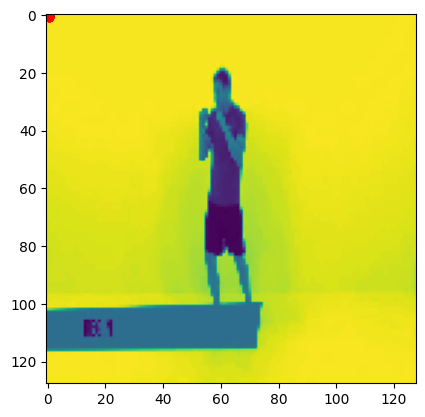

In [41]:
import h5py
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

class HDF5DataGenerator(Sequence):
    """
    Custom data generator for HDF5 data with video fragments and labels per video.
    """

    def __init__(self, hdf5_file, batch_size, target_size, max_frames, augmentation=None):
        self.hdf5_file = hdf5_file
        self.batch_size = batch_size
        self.target_size = target_size
        self.max_frames = max_frames
        self.augmentation = augmentation
        self.indices = self._get_indices()
        self.on_epoch_end()

    def _get_indices(self):
        # Load data information from the HDF5 file
        with h5py.File(self.hdf5_file, "r") as f:
            return list(f.keys())

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        # Generate a single batch of data and labels
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Load data and labels for the current batch of videos
        X, X_keypoints, y = self.__data_generation(batch_indices)

        return (X, X_keypoints), y

    def on_epoch_end(self):
        # Shuffle indices for each epoch
        np.random.shuffle(self.indices)

    def __data_generation(self, batch_indices):
      # Initialize arrays for frames, keypoints, and labels
      X = np.zeros((self.batch_size, self.max_frames, *self.target_size, IMG_CHANNELS), dtype=np.float32)
      X_keypoints = np.zeros((self.batch_size, self.max_frames, BODY_KEYPOINTS, 3), dtype=np.float32)
      y = np.zeros((self.batch_size,), dtype=np.float32)

      with h5py.File(self.hdf5_file, 'r') as f:
        for i, idx in enumerate(batch_indices):
          frames = f[f'{idx}/frames'][:]
          keypoints = f[f'{idx}/keypoints'][:]
          label = f[f'{idx}/label'][()]


          if APPLY_GRAYSCALE:
            frames = np.expand_dims(frames, axis=-1)  # Add channel dimension


          # Check for NaNs in the original frames and keypoints
          if np.isnan(frames).any() or np.isnan(keypoints).any():
            print(f"Warning: Found NaN in frames or keypoints for index {idx}. Replacing with default values.")
            frames = np.zeros_like(frames)
            keypoints = np.zeros_like(keypoints)

          # Pad or truncate frames to max_frames
          if frames.shape[0] < self.max_frames:
            pad_width = self.max_frames - frames.shape[0]
            # Pad with copies of the last frame
            last_frame = frames[-1]
            last_keypoints = keypoints[-1]

            # # Modify the padding logic for frames:
            # if pad_width > 0:
            #     last_frame_padded = np.tile(last_frame, (pad_width, 1, 1))  # Remove np.expand_dims here
            #     frames = np.concatenate([frames, last_frame_padded], axis=0)

            frames = np.concatenate([frames, np.tile(last_frame, (pad_width, 1, 1, 1))], axis=0)
            keypoints = np.concatenate([keypoints, np.tile(last_keypoints, (pad_width, 1, 1))], axis=0)
          elif frames.shape[0] > self.max_frames:
            frames = frames[:self.max_frames]
            keypoints = keypoints[:self.max_frames]

          if self.augmentation:
              augmented_frames = []
              for frame in frames:
                  augmented_frame = self.augmentation.random_transform(frame)
                  augmented_frames.append(augmented_frame)
              frames = np.array(augmented_frames)

          X[i] = frames
          X_keypoints[i] = keypoints
          y[i] = label

      return X, X_keypoints, y


# Create data generators
# train_generator = HDF5DataGenerator(DATASET_TRAIN_PATH, batch_size=8, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)
# val_generator = HDF5DataGenerator(DATASET_VAL_PATH, batch_size=8, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)
test_generator = HDF5DataGenerator('test.hdf5', batch_size=8, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)

# Example function to check the generator output
def check_generator_output(generator, batch_index=0):
    (frames_batch, keypoints_batch), labels_batch = generator[batch_index]

    print(f"Batch shape (frames): {frames_batch.shape}")
    print(f"Batch shape (keypoints): {keypoints_batch.shape}")
    print(f"Batch shape (labels): {labels_batch.shape}")

    # Optionally visualize the first frame and keypoints
    first_frame = frames_batch[0][0]
    first_keypoints = keypoints_batch[0][0]

    plt.imshow(first_frame.astype(np.uint8))
    for x, y, _ in first_keypoints:
        plt.scatter(x, y, c='red')
    plt.show()

# Check the generator output
check_generator_output(test_generator, batch_index=0)


## Load the data

In [42]:
def load_dataset_data(dataset_name):
    X = []
    y = []
    frame_lengths = []
    with h5py.File(dataset_name, "r") as hdf5_file:
        video_names = list(hdf5_file.keys())
        for video_name in video_names:
            # Access frames and labels datasets for the specific video
            frames = hdf5_file[f"{video_name}/frames"][:]
            labels = hdf5_file[f"{video_name}/labels"][:]

            # Append data and label to batch lists
            X.append(frames)
            y.append(labels)
            frame_lengths.append(frames.shape[0])

    return np.array(X), np.array(y), np.array(frame_lengths)

In [43]:
def get_dataset_size(dataset_name):
  size = 0
  with h5py.File(dataset_name, 'r') as f:
    video_names = list(f.keys())
    for v in video_names:
      size += len(f[f'{v}/frames'])

  return size

get_dataset_size(DATASET_TRAIN_PATH)

1115

In [44]:
if INSTALL_STUFF:
    !pip install tensorboard

# launch this command in your terminal if you want to see the tensorboard
# !tensorboard --logdir=C:\Users\margo\OneDrive\UOC\projects\thesis\logs

# Open http://localhost:6006 in your browser to access tensorboard

## Training

### Training using generators

In [45]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, CSVLogger

import os

def train_model_using_generators(model, epochs=EPOCHS):
    """Trains a model on the provided data using data generators.

    Args:
      model: The Keras model to be trained.
      epochs: Number of training epochs.

    Returns:
      The trained model, train history, and val generator
    """

    # Generators
    train_generator = HDF5DataGenerator(DATASET_TRAIN_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)
    val_generator = HDF5DataGenerator(DATASET_VAL_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH), max_frames=MAX_NUM_FRAMES)

    # Callbacks
    my_callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'checkpoints', 'model.{epoch:02d}-{val_loss:.2f}.keras'),
                        save_best_only=True),
        TensorBoard(log_dir=LOGS_PATH),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
        CSVLogger("training_history.csv")
    ]

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    train_history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=my_callbacks
    )

    return model, train_history, val_generator


## Model

In [46]:
from keras.layers import Conv3D, Conv2D, MaxPooling2D, TimeDistributed, Flatten, LSTM, Dropout, Dense, BatchNormalization, MaxPooling3D
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os

def create_video_model_deprecated(input_shape=(MAX_NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=1):
    model = Sequential([
        Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),  # Pool only in spatial dimensions

        Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),  # Pool only in spatial dimensions

        Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),  # Pool only in spatial dimensions

        Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),  # Pool only in spatial dimensions

        TimeDistributed(Flatten()),  # Flatten the output of each time step
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)),  # L2 regularization
        Dropout(0.5),  # Dropout to prevent overfitting

        LSTM(32, kernel_regularizer=l2(0.01)),  # Another LSTM layer for added depth
        Dropout(0.5),

        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  # Sigmoid for binary classification
    ])

    return model

# Create the video model
video_model_deprecated = create_video_model_deprecated()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, MaxPooling3D, TimeDistributed, Flatten, LSTM, Dropout, Dense, concatenate
from tensorflow.keras.regularizers import l2

def create_video_model(input_shape_frames=(MAX_NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                       input_shape_keypoints=(MAX_NUM_FRAMES, BODY_KEYPOINTS, 3), num_classes=1):

    # Frame input branch
    frames_input = Input(shape=input_shape_frames, name='frames_input')
    x = Conv3D(32, (3,3,3), activation='relu', padding='same')(frames_input)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1,2,2))(x)
    x = Conv3D(64, (3,3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1,2,2))(x)
    x = Conv3D(128, (3,3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1,2,2))(x)
    x = Conv3D(128, (3,3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1,2,2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = LSTM(32, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Keypoints input branch
    keypoints_input = Input(shape=input_shape_keypoints, name='keypoints_input')
    y = TimeDistributed(Flatten())(keypoints_input)
    y = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(y)
    y = Dropout(0.5)(y)
    y = LSTM(32, kernel_regularizer=l2(0.01))(y)
    y = Dropout(0.5)(y)
    y = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(y)
    y = Dropout(0.5)(y)

    # Combine both branches
    combined = concatenate([x, y])
    z = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(combined)
    z = Dropout(0.5)(z)
    z = Dense(num_classes, activation='sigmoid')(z)

    model = Model(inputs=[frames_input, keypoints_input], outputs=z)
    return model

# Create the model
input_shape_frames = (MAX_NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
input_shape_keypoints = (MAX_NUM_FRAMES, BODY_KEYPOINTS, 3)
video_model = create_video_model(input_shape_frames=input_shape_frames, input_shape_keypoints=input_shape_keypoints, num_classes=1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ frames_input (InputLayer) │ (None, 40, 128, 128,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_8 (Conv3D)         │ (None, 40, 128, 128,   │            896 │ frames_input[0][0]     │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 40, 128, 128,   │            128 │ conv3d_8[0][0]         │
│ (BatchNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_8           │ (None, 40, 64, 64, 32) │              0 │ batch_normalization_8… │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_9 (Conv3D)         │ (None, 40, 64, 64, 64) │         55,360 │ max_pooling3d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 40, 64, 64, 64) │            256 │ conv3d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_9           │ (None, 40, 32, 32, 64) │              0 │ batch_normalization_9… │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_10 (Conv3D)        │ (None, 40, 32, 32,     │        221,312 │ max_pooling3d_9[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 40, 32, 32,     │            512 │ conv3d_10[0][0]        │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_10          │ (None, 40, 16, 16,     │              0 │ batch_normalization_1… │
│ (MaxPooling3D)            │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_11 (Conv3D)        │ (None, 40, 16, 16,     │        442,496 │ max_pooling3d_10[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 40, 16, 16,     │            512 │ conv3d_11[0][0]        │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_11          │ (None, 40, 8, 8, 128)  │              0 │ batch_normalization_1… │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keypoints_input      

 Total params: 3,445,825 (13.14 MB)

 Trainable params: 3,445,121 (13.14 MB)

 Non-trainable params: 704 (2.75 KB)

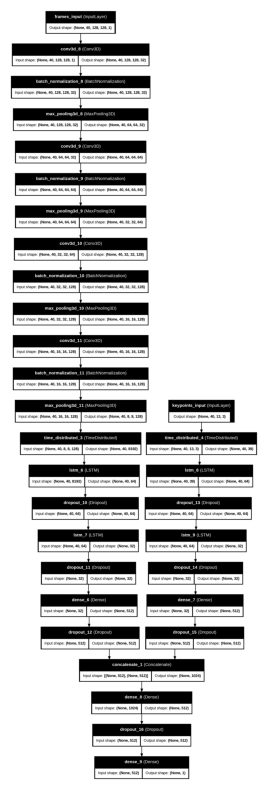

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from scipy import stats as st
import progressbar

m = create_video_model()
m.summary()

def plot_model_diagram(model, file_path='model_diagram.png'):
    plot_model(model, to_file=file_path, show_shapes=True, show_layer_names=True)
    img = plt.imread(file_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

plot_model_diagram(m)

# Evaluation

## Offline Evaluation

In [69]:
from keras.models import load_model

# Train the model
model = create_video_model()
train_history = None
val_generator = None
if LOAD_MODEL:
    trained_model = load_model(os.path.join(MODELS_PATH, 'basic_model.keras'))
else:
    trained_model, train_history, val_generator = train_model_using_generators(model, epochs=EPOCHS)
    history = train_history.history
model.save(os.path.join(MODELS_PATH, 'basic_model.keras'))

In [70]:
import pickle
if train_history is not None:
  with open('train_history.pkl', 'wb') as f:
    pickle.dump(train_history.history, f)

with open('train_history.pkl', 'rb') as f:
  history = pickle.load(f)

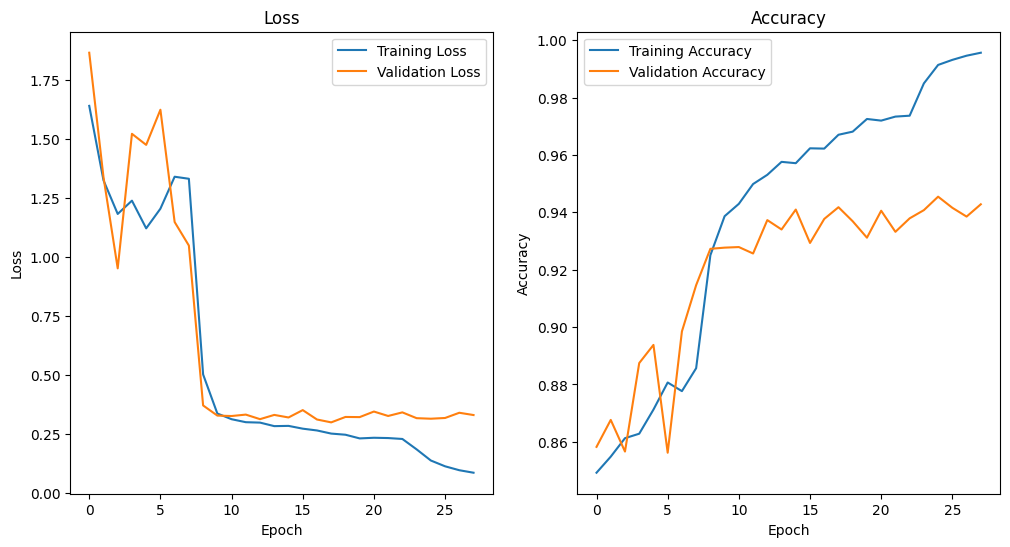

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score


def show_model_metrics(history, model, val_generator):
    # Access training and validation loss/accuracy
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    train_acc = history["accuracy"]
    val_acc = history["val_accuracy"]

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


    if val_generator is None:
        return

    # Evaluate model on validation data
    y_true = []
    y_pred = []

    for batch_x, batch_y in val_generator:
        y_true.extend(batch_y)
        y_pred_batch = model.predict(batch_x)
        y_pred.extend(np.round(y_pred_batch).astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Ensure both y_true and y_pred are binary and have the same shape
    if y_true.ndim > 1:
        y_true = y_true.flatten()
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()

    # Trim y_pred to match the length of y_true if needed
    if len(y_pred) > len(y_true):
        y_pred = y_pred[:len(y_true)]
    elif len(y_true) > len(y_pred):
        y_true = y_true[:len(y_pred)]

    # Classification report
    print("Classification Report:")
    print('y_true', y_true);
    print('y_pred', y_pred);
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Violent']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Violent'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)

    # Plot Precision-Recall curve
    plt.figure()
    plt.step(recall, precision, where='post', label='Precision-Recall curve (AP = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower left")
    plt.show()


show_model_metrics(history, trained_model, val_generator)